In [11]:
# ============================================================
# 0. CLONAR PROJETO PFVC E ENTRAR NA PASTA
# ============================================================
import os

REPO_URL = "https://github.com/danisilva1110-spec/PFVC.git"
REPO_NAME = "PFVC"

if not os.path.exists(REPO_NAME):
    !git clone {REPO_URL}

%cd {REPO_NAME}
!ls


Cloning into 'PFVC'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 47 (delta 4), reused 12 (delta 1), pack-reused 32 (from 1)
Receiving objects: 100% (47/47), 45.71 MiB | 38.12 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/PFVC/PFVC
classes_foco.json      lixao2.jpg  lixao5.jpg			 PFVC1.ipynb
classes_trashnet.json  lixao3.jpg  modelo_foco_lixo.pth		 PFVC2.ipynb
lixao1.jpg	       lixao4.jpg  modelo_resnet18_trashnet.pth  README.md


In [12]:
# ============================================================
# 0.5. FUNÇÕES PARA JUNTAR CAIXAS (NMS SIMPLES)
# ============================================================

def iou_boxes(b1, b2):
    """
    Calcula IoU entre duas caixas no formato dict:
    {"x":..., "y":..., "w":..., "h":...}
    """
    x1 = max(b1["x"], b2["x"])
    y1 = max(b1["y"], b2["y"])
    x2 = min(b1["x"] + b1["w"], b2["x"] + b2["w"])
    y2 = min(b1["y"] + b1["h"], b2["y"] + b2["h"])

    inter_w = max(0, x2 - x1)
    inter_h = max(0, y2 - y1)
    inter = inter_w * inter_h

    if inter <= 0:
        return 0.0

    area1 = b1["w"] * b1["h"]
    area2 = b2["w"] * b2["h"]
    union = area1 + area2 - inter
    if union <= 0:
        return 0.0

    return inter / union


def nms_focos(focos, iou_thresh=0.4):
    """
    Non-Maximum Suppression simples:
    mantém apenas uma caixa por grupo de caixas muito sobrepostas.
    Ordena pelos scores de 'prob_lixo'.
    """
    if not focos:
        return []

    # ordena por prob_lixo (maior primeiro)
    focos = sorted(focos, key=lambda f: f["prob_lixo"], reverse=True)
    kept = []

    while focos:
        best = focos.pop(0)
        kept.append(best)

        novos = []
        for f in focos:
            if iou_boxes(best, f) < iou_thresh:
                novos.append(f)
        focos = novos

    return kept


In [13]:
# ============================================================
# 1. IMPORTS E DEVICE
# ============================================================
import os
import json
from collections import Counter

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [14]:
# ============================================================
# 2. CARREGAR MODELO A: DETECÇÃO DE FOCOS (lixo / nao_lixo)
# ============================================================
FOCO_MODEL_PATH = "modelo_foco_lixo.pth"
FOCO_CLASSES_PATH = "classes_foco.json"

with open(FOCO_CLASSES_PATH, "r") as f:
    foco_classes = json.load(f)

print("Classes foco:", foco_classes)
num_foco_classes = len(foco_classes)

# índice da classe "lixo" (não assumimos que é 0)
idx_lixo = foco_classes.index("lixo")

# arquitetura igual ao treino
modelo_foco = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for p in modelo_foco.parameters():
    p.requires_grad = False
in_features = modelo_foco.fc.in_features
modelo_foco.fc = nn.Linear(in_features, num_foco_classes)

state_dict_foco = torch.load(FOCO_MODEL_PATH, map_location=device)
modelo_foco.load_state_dict(state_dict_foco)

modelo_foco = modelo_foco.to(device)
modelo_foco.eval()

# transform igual ao treino de focos
input_size = 224
foco_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("Modelo A (focos) carregado.")


Classes foco: ['lixo', 'nao_lixo']
Modelo A (focos) carregado.


In [15]:
# ============================================================
# 3. CARREGAR MODELO B: TRASHNET (TIPO DE LIXO)
# ============================================================
TRASH_MODEL_PATH = "modelo_resnet18_trashnet.pth"
TRASH_CLASSES_PATH = "classes_trashnet.json"

with open(TRASH_CLASSES_PATH, "r") as f:
    trash_classes = json.load(f)

print("Classes trashnet:", trash_classes)
num_trash_classes = len(trash_classes)

modelo_trash = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
for p in modelo_trash.parameters():
    p.requires_grad = False
in_features = modelo_trash.fc.in_features
modelo_trash.fc = nn.Linear(in_features, num_trash_classes)

state_dict_trash = torch.load(TRASH_MODEL_PATH, map_location=device)
modelo_trash.load_state_dict(state_dict_trash)

modelo_trash = modelo_trash.to(device)
modelo_trash.eval()

# transform igual ao val/test do TrashNet
trash_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

print("Modelo B (tipo de lixo) carregado.")


Classes trashnet: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Modelo B (tipo de lixo) carregado.


In [16]:
# ============================================================
# 4. FUNÇÕES DE CLASSIFICAÇÃO POR PATCH
# ============================================================

def classify_foco_from_bgr(patch_bgr):
    """
    Usa Modelo A para dizer probabilidade de 'lixo' neste patch.
    Retorna (is_lixo_predito, prob_lixo, classe_predita).
    """
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(patch_rgb)

    x = foco_transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = modelo_foco(x)
        probs = torch.softmax(logits, dim=1)[0]

    prob_lixo = float(probs[idx_lixo])
    pred_idx = int(torch.argmax(probs))
    pred_label = foco_classes[pred_idx]

    return (pred_label == "lixo"), prob_lixo, pred_label


def classify_trash_from_bgr(patch_bgr):
    """
    Usa Modelo B (TrashNet) para classificar o tipo de lixo.
    Retorna (label, confianca).
    """
    patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(patch_rgb)

    x = trash_transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = modelo_trash(x)
        probs = torch.softmax(logits, dim=1)[0]

    pred_idx = int(torch.argmax(probs))
    label = trash_classes[pred_idx]
    conf = float(probs[pred_idx])

    return label, conf


In [17]:
# ============================================================
# 5b. PIPELINE EM DUAS ETAPAS:
#     1) DETECTAR FOCOS COM MODELO A
#     2) JUNTAR CAIXAS E CLASSIFICAR TIPO COM MODELO B
# ============================================================

def analisar_imagem_cena_v2(path_img,
                            patch_size=224,
                            step=224,
                            foco_threshold=0.6,
                            tipo_threshold=0.5,
                            iou_nms=0.4,
                            mostrar=True):
    """
    Versão 2 do pipeline:
    1) Usa apenas o Modelo A para marcar patches como 'lixo'.
    2) Aplica NMS para juntar caixas sobrepostas (um foco por região).
    3) Para cada foco, recorta a região e usa o Modelo B (TrashNet) para tipificar.
    """
    img = cv2.imread(path_img)
    if img is None:
        raise ValueError(f"Não foi possível carregar a imagem: {path_img}")

    h, w = img.shape[:2]
    print(f"Imagem: {w}x{h}")

    # ---------- 1) Passo de detecção com Modelo A ----------
    candidatos = []

    for y in range(0, h - patch_size + 1, step):
        for x in range(0, w - patch_size + 1, step):
            patch = img[y:y+patch_size, x:x+patch_size]

            # mesma lógica do classify_foco_from_bgr,
            # mas só nos interessa a probabilidade de 'lixo'
            patch_rgb = cv2.cvtColor(patch, cv2.COLOR_BGR2RGB)
            img_pil = Image.fromarray(patch_rgb)
            x_t = foco_transform(img_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                logits = modelo_foco(x_t)
                probs = torch.softmax(logits, dim=1)[0]

            prob_lixo = float(probs[idx_lixo])
            pred_idx = int(torch.argmax(probs))
            pred_label = foco_classes[pred_idx]

            if pred_label == "lixo" and prob_lixo >= foco_threshold:
                candidatos.append({
                    "x": x,
                    "y": y,
                    "w": patch_size,
                    "h": patch_size,
                    "prob_lixo": prob_lixo,
                })

    print(f"Candidatos (antes do NMS): {len(candidatos)}")

    # ---------- 2) NMS: juntar caixas sobrepostas ----------
    focos_nms = nms_focos(candidatos, iou_thresh=iou_nms)
    print(f"Focos após NMS: {len(focos_nms)}")

    # ---------- 3) Classificar tipo de lixo com Modelo B ----------
    focos_finais = []
    tipos_contagem = Counter()

    for f in focos_nms:
        x, y, w0, h0 = f["x"], f["y"], f["w"], f["h"]

        # recorta a região do foco; opcional: ampliar um pouco
        margem = 0.1  # 10% de margem em cada lado
        dx = int(w0 * margem)
        dy = int(h0 * margem)

        x1 = max(0, x - dx)
        y1 = max(0, y - dy)
        x2 = min(w, x + w0 + dx)
        y2 = min(h, y + h0 + dy)

        patch_foco = img[y1:y2, x1:x2]

        if patch_foco.size == 0:
            continue

        tipo_label, tipo_conf = classify_trash_from_bgr(patch_foco)

        if tipo_conf < tipo_threshold:
            # se o modelo B não estiver confiante, a gente pode descartar
            continue

        f_out = {
            "x": x1,
            "y": y1,
            "w": x2 - x1,
            "h": y2 - y1,
            "prob_lixo": f["prob_lixo"],
            "tipo": tipo_label,
            "tipo_conf": tipo_conf,
        }
        focos_finais.append(f_out)
        tipos_contagem[tipo_label] += 1

    print("Focos detectados (após tipificação):", len(focos_finais))

    # ---------- Estatísticas ----------
    if len(focos_finais) > 0:
        total = sum(tipos_contagem.values())
        porcentagens = {k: 100.0 * v / total for k, v in tipos_contagem.items()}
    else:
        porcentagens = {}

    print("\nContagem por tipo:")
    for k, v in tipos_contagem.items():
        print(f"  {k}: {v}")

    print("\nPorcentagens:")
    for k, v in porcentagens.items():
        print(f"  {k}: {v:.1f}%")

    # ---------- Desenhar caixas ----------
    img_out = img.copy()
    for f in focos_finais:
        x1, y1, w0, h0 = f["x"], f["y"], f["w"], f["h"]
        tipo = f["tipo"]
        cv2.rectangle(img_out, (x1, y1), (x1+w0, y1+h0), (0, 255, 0), 2)
        cv2.putText(img_out, tipo, (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

    if mostrar:
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Focos de lixo detectados e tipificados (v2)")
        plt.show()

    stats = {
        "focos": focos_finais,
        "contagem": tipos_contagem,
        "porcentagens": porcentagens,
    }

    return img_out, stats


Imagem: 3840x2160
Candidatos (antes do NMS): 3
Focos após NMS: 3
Focos detectados (após tipificação): 3

Contagem por tipo:
  paper: 3

Porcentagens:
  paper: 100.0%


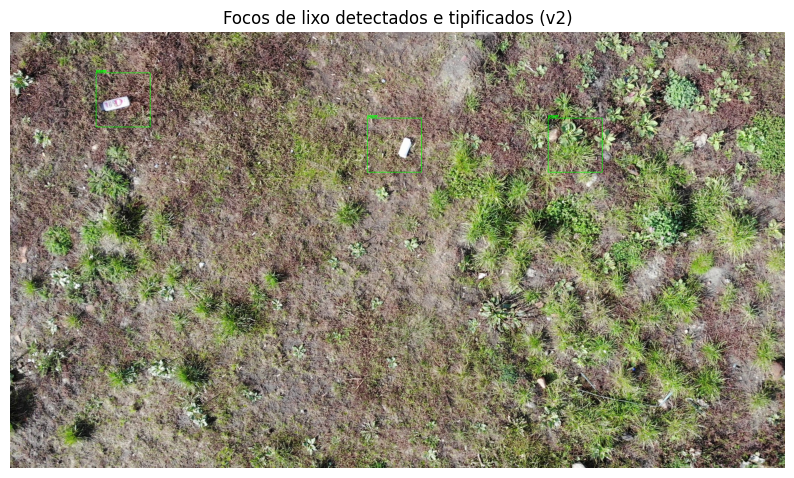

In [27]:
caminho_imagem = "lixao5.jpg"


img_out, stats = analisar_imagem_cena_v2(
    caminho_imagem,
    patch_size=224,
    step=224,        # ou 224, depende do que ficou melhor
    foco_threshold=0.5,
    tipo_threshold=0.3,   # confiança mínima do TrashNet
    iou_nms=0.4           # quanto mais baixo, mais agressivo junta caixas
)